# Data Loader
#### Extracting data and adjusting data to numerical ones. 
#### Adding distance and angle by calculating with (x, y) point.
#### Addition column of GoalB to store goal data as binary for easy use sklearn model

In [1]:
import numpy as np 
import pandas as pd
import json
import glob

path = './events/*.json'
dfs = []
for file in glob.glob(path):
    with open(file) as f:
        json_data = pd.json_normalize(json.loads(f.read()))
        json_data['site'] = file.rsplit("/", 1)[-1]
    dfs.append(json_data)
data = pd.concat(dfs)

train = pd.DataFrame(data)

path2 = "players.json" 

with open(path2) as f:
    play = json.load(f)

players = pd.DataFrame(play)




pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']

shots_model = pd.DataFrame(columns=["Goal","X","Y"], dtype=object)

for i,shot in shots.iterrows():
    
    
    shots_model.at[i,'Header'] = 0
    for tag in shot['tags']:
        if tag['id'] == 403:
            shots_model.at[i,'Header'] = 1
    
    
    #take distance from center of goal at y = 50, x position of goal is always 100
    shots_model.at[i,'X'] = 100-shot['positions'][0]['x']
    shots_model.at[i,'Y'] = shot['positions'][0]['y']
    shots_model.at[i,'C'] = abs(shot['positions'][0]['y'] - 50)
        
    #distance in meters
        
    x = shots_model.at[i,'X']* 105/100
    y = shots_model.at[i,'C']* 65/100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        
    angle = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        
    if angle < 0:
        angle = np.pi + angle
        
    shots_model.at[i,'Angle'] = angle
        
    #goal check
    shots_model.at[i,'Goal'] = 0
    shots_model.at[i,'GoalB'] = bin(0)
    shots_model.at[i,'Counter Attack'] = 0
    shots_model.at[i, 'Blocked'] = 0
    shots_model.at[i, 'Right Foot'] = 0
    shots_model.at[i,'wyId'] = shot['playerId']
    
    if shot['matchPeriod'] == '1H':
        shots_model.at[i, 'First Half'] = 1
    
    else:
        shots_model.at[i,'First Half'] = 0
        
    for tags in shot['tags']:
        if tags['id'] == 101:
            shots_model.at[i,'Goal'] = 1
            shots_model.at[i,'GoalB'] = bin(1)
            
        if tags['id'] == 1901:
            shots_model.at[i, 'Counter Attack'] = 1
        
        if tags['id'] == 2101:
            shots_model.at[i, 'Blocked'] = 1
        
        if tags['id'] == 402:
            shots_model.at[i, 'Right Foot'] = 1
            
            
        
shots_model['angle_degrees'] = shots_model['Angle'] * 180 / np.pi

shots_model = shots_model.merge(players, left_on = 'wyId' , right_on = 'wyId')

for i,shot in shots_model.iterrows():
    shots_model.at[i, 'strong foot'] = 0
    
    if shot['Right Foot'] == 1:
        if shot['foot'] == 'right':
            shots_model.at[i, 'strong foot'] = 1
    
    elif shot['Right Foot'] == 0:
        if shot['foot'] == 'left':
            shots_model.at[i, 'strong foot'] = 1

### drop out the data that is not related with the goal accuracy

In [2]:
shots_model.drop(['passportArea', 'firstName','middleName', 'lastName',
                  'birthDate','role', 'birthArea', 'foot', 'shortName', 
                  'currentNationalTeamId', 'currentTeamId'], axis = 1, inplace = True)

### current data information

In [3]:
shots_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41843 entries, 0 to 41842
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Goal            41843 non-null  object 
 1   X               41843 non-null  object 
 2   Y               41843 non-null  object 
 3   Header          41843 non-null  float64
 4   C               41843 non-null  float64
 5   Distance        41843 non-null  float64
 6   Angle           41843 non-null  float64
 7   GoalB           41843 non-null  object 
 8   Counter Attack  41843 non-null  float64
 9   Blocked         41843 non-null  float64
 10  Right Foot      41843 non-null  float64
 11  wyId            41843 non-null  float64
 12  First Half      41843 non-null  float64
 13  angle_degrees   41843 non-null  float64
 14  weight          41843 non-null  int64  
 15  height          41843 non-null  int64  
 16  strong foot     41843 non-null  float64
dtypes: float64(11), int64(2), objec

### Split dataset to testing data and training data with sklearn function: train_test_split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = shots_model[['Distance', 'angle_degrees']]#
y = shots_model[['GoalB','Goal']]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train_BI, y_test_BI = train_test_split(X,y, train_size=0.8)

y_train_int = y_train_BI['Goal']
y_train = y_train_BI['GoalB']
y_test_int = y_test_BI['Goal']
y_test = y_test_BI['GoalB']

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)
print(type(y_train_int.iloc[0]), type(y_test_int.iloc[0]))

(33474, 2)
(33474,)
(8369, 2)
(8369,)
<class 'int'> <class 'int'>


# Training data with 9 sklearn model and visualize their classifying result to understand the relationship among distance, angle and goals

### KNN model
we take k as 5 and predict the goal based on the nearest 5 points. If mostly points is one, then the model will guess one, otherwise it will guess zero.

### Linear SVM
It mainly use support vectors to calculate margin and maximize it. The margin is calculate by the projection vector that obtained from two vectors. And then maximize margin under the condition that there is no point in the middle line.

### RBF SVM
It's like Linear SVM but Project all data to higher dimensions so it can be easier to find linear hyperplanes for classifying.

### Decision Tree
Decision Tree is learned to offer a series of questions through the features of training data, and then predict the category based on the questions. 

### Random forest 
Random forest is derived from the decision tree but enhance its ability. It adopt several decision trees and train it with randomly picked-data. Then, take the majority decision from all decision trees as the prediction.

### AdaBoost 
Just like random forest, AdaBoost is derived from and adopt several decision trees as classifiers to enhance its ability in classification. But adaboost trains them with several initialized weights distribution of the training data.By increasing the weight of the wrong data from the old classifier, the weighted training samples are used to train the new classifier. Therefore, the new classifier will learn more characteristics of the misclassified data.

### Nueral Network
Use neural network with default 100 hidden layers to train a model as a non-linear classifier.

### Gaussian Naive Bayes
This model computes the posterior probability for different distances and angles and then use this to predict the probability of goals.  

### QDA classifier
It adopts the algorithm of linear discriminant analysis algorithm but additionally calculates the covariance of two variables (here is angle and distance) to get the relationship between the variables.


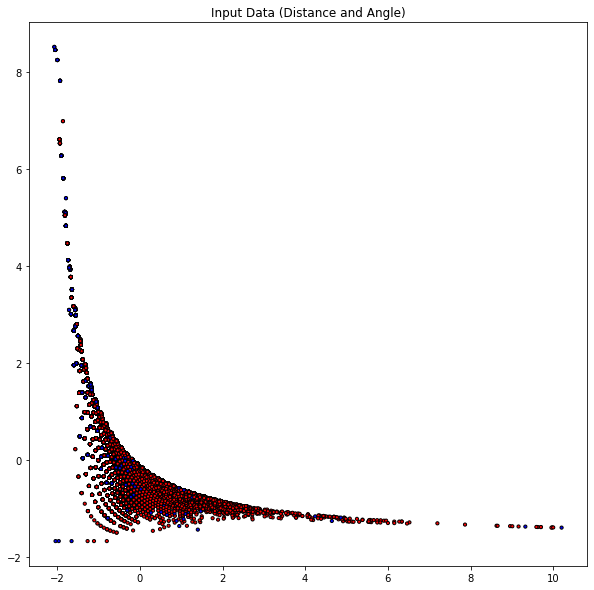

Nearest Neighbors 0.8850519775361453


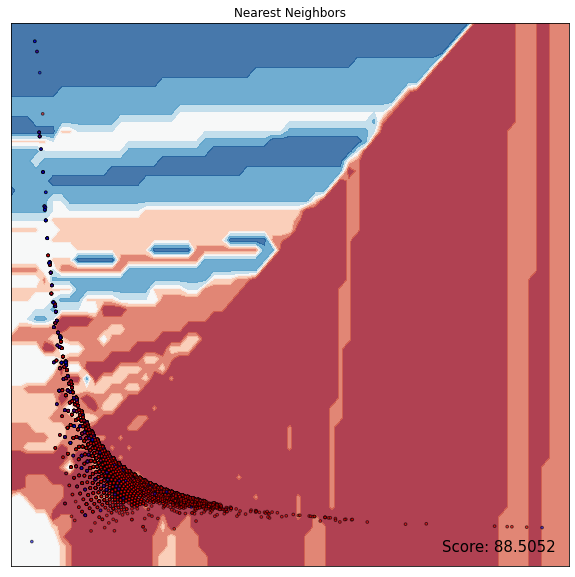

Linear SVM 0.8941331102879675


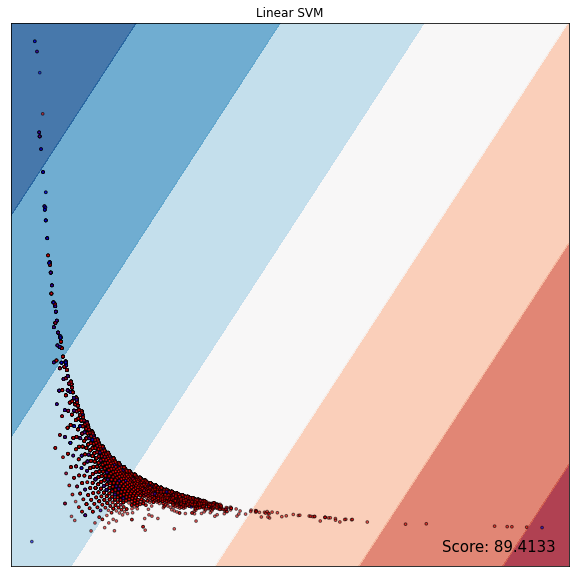

RBF SVM 0.8965228820647628


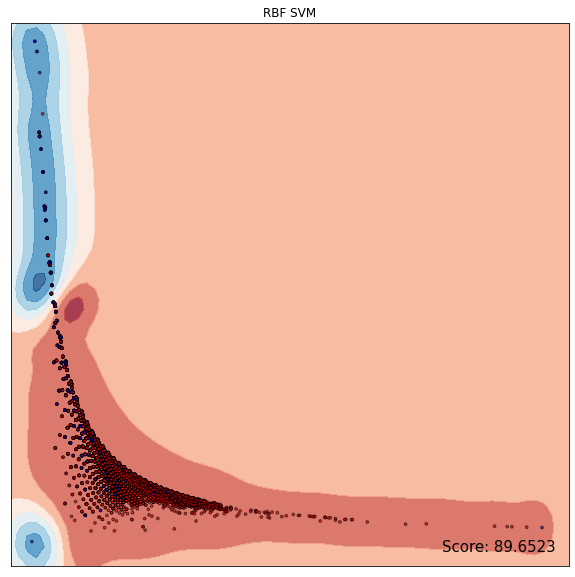

Decision Tree 0.8966423706536025


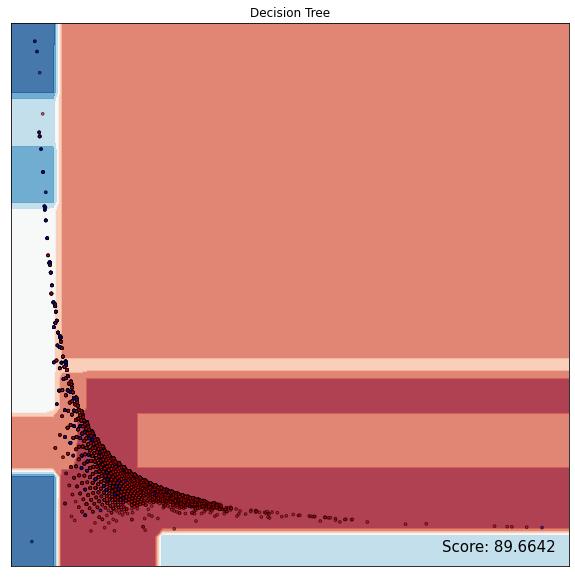

Random Forest 0.895925439120564


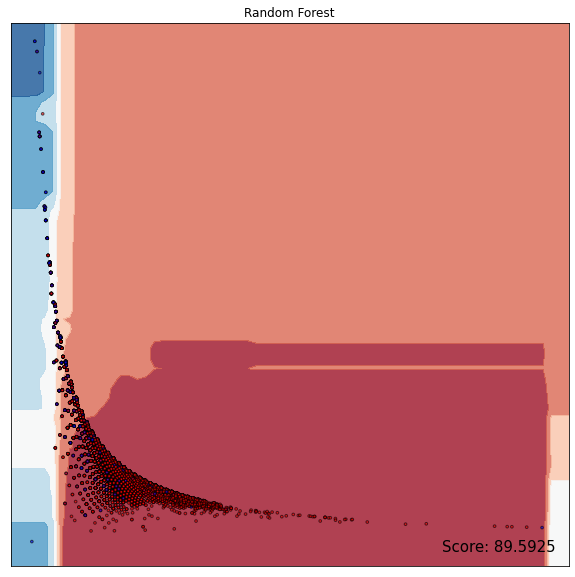

Neural Net 0.896403393475923


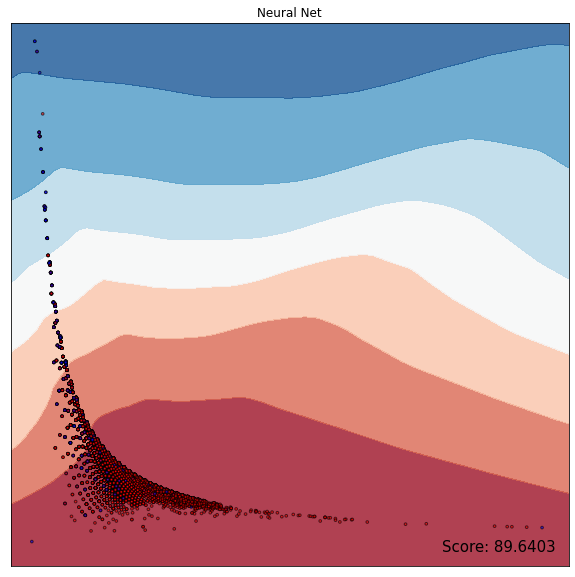

AdaBoost 0.895925439120564


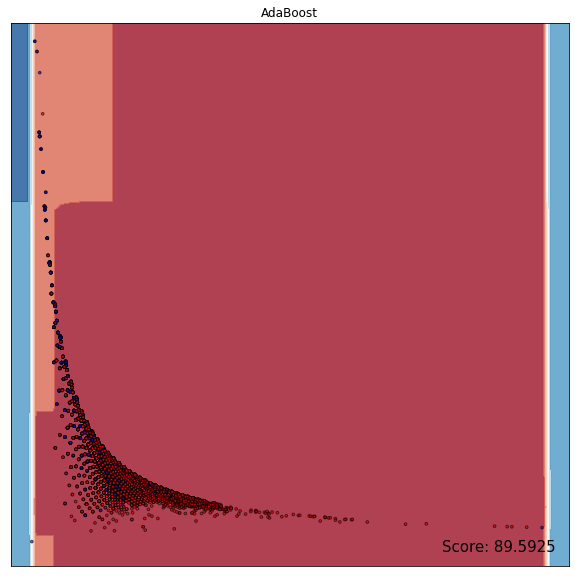

Naive Bayes 0.8738200501852074


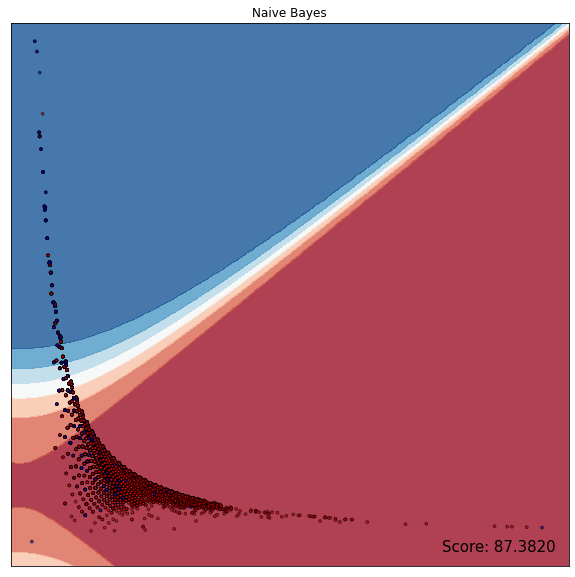

QuadraticDiscriminantAnalysis 0.8839765802365874


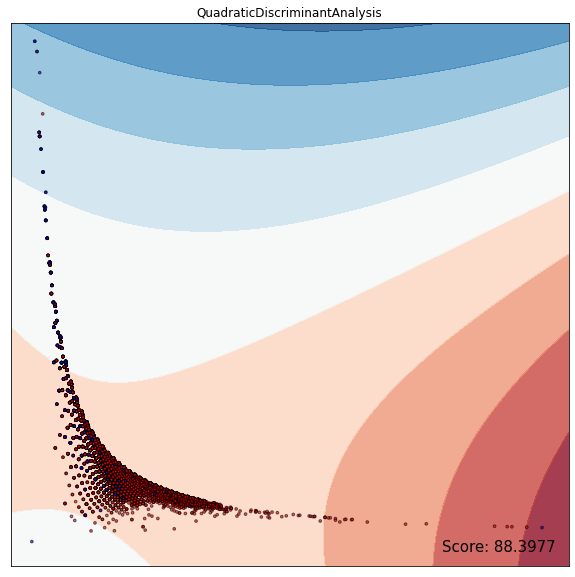

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QuadraticDiscriminantAnalysis",
]

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.5),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=0.01, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

h = 0.2


x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_title('Input Data (Distance and Angle)')

ax.scatter(X_train[:, 0], X_train[:, 1], c = y_train_int, cmap=cm_bright, edgecolors="k", s=10)
plt.savefig('./image/InputData.jpg')
plt.show()

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(name, score)


    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

    # Plot the testing points
    ax.scatter(X_test[:, 0],X_test[:, 1],c=y_test_int,cmap=cm_bright,edgecolors='k',alpha=0.6,s=7)
    ax.set_title(name)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax.text(
        xx.max() - 0.3,
        yy.min() + 0.3,
        ("Score: %.4f" % (score*100)).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    plt.savefig('./image/' + name + '.jpg')
    plt.show()